In [1]:
import numpy  as np
from scipy import signal as sig
from scipy import io as sio
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize'] = [17, 6]

In [2]:
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_lead_len = len(ecg_one_lead)
qrs_detections = mat_struct['qrs_detections']
qrs_len = len(qrs_detections)
qrs_detections = qrs_detections.reshape(qrs_detections.shape[0],)
ecg_one_lead = ecg_one_lead.reshape(ecg_one_lead.shape[0],)
N = len(ecg_one_lead)

fs = 1000
Ts = 1/fs
nn = fs
W0 = fs/2
df = fs/nn



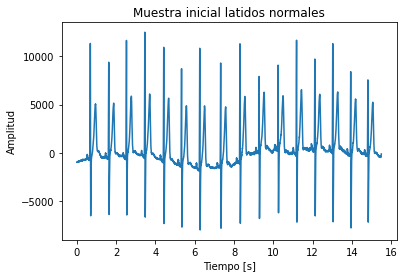

In [3]:
val_in=9500
val_fin=25000
ecg_reposo = ecg_one_lead[val_in:val_fin]

N_reposo = len(ecg_reposo)
t_reposo = np.arange(start = 0, stop = N_reposo*Ts, step = Ts)

det_ecg_reposo = qrs_detections[
    np.logical_and(qrs_detections>val_in, qrs_detections<val_fin)] - val_in

det_len_rep = len(det_ecg_reposo)

plt.figure(1)
plt.plot(t_reposo, ecg_reposo)


plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Muestra inicial latidos normales')
plt.show()

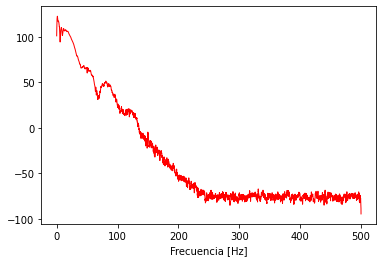

In [4]:
nperseg = N_reposo//10
sig1_welch_ff, sig1_welch_Pxx = sig.welch(x = ecg_reposo, fs = fs, window = 'blackman', average='median',
                                          axis=0, nfft = N_reposo,nperseg=N_reposo//10,noverlap=nperseg//2)
sig1_welch_Pxx_db = 20* np.log10(sig1_welch_Pxx)

plt.figure(5)
plt.xlabel("Frecuencia [Hz]")

plt.plot( [], [], label="Espectro ECG",          color='red', linewidth=.1)
plt.plot( sig1_welch_ff,  sig1_welch_Pxx_db,        color='red', linewidth=1, zorder=5)



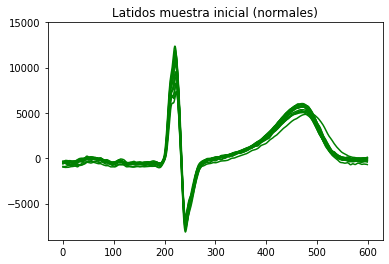

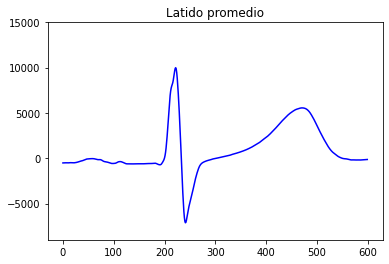

In [5]:
wleft = 220; wright = 380; w = wleft+wright
muestras_ecg = np.zeros((wleft+wright, det_len_rep))

for i in range(det_len_rep):
    x = det_ecg_reposo[i]
    muestras_ecg[:,i] = ecg_reposo[x-wleft:x+wright].reshape(w,)
    muestras_ecg[:,i] -= np.median(muestras_ecg[:,i])

plt.figure(6)

plt.plot(muestras_ecg, 'g')
plt.title('Latidos muestra inicial (normales)')
plt.ylim([-9000,15000])

plt.figure(7)
plt.plot(np.mean(muestras_ecg,axis=1), 'b') ##Promedio
plt.title('Latido promedio')
plt.ylim([-9000,15000])
plt.show()


In [14]:
Nm = len(muestras_ecg)
nperseg = Nm//10

welch_ff_ocg, welch_spec_ocg = sig.welch(muestras_ecg,   fs=fs, window='blackman', nfft=Nm, nperseg=nperseg, 
                                         noverlap=nperseg//2,  average='median',  axis=0 )
media_spec = np.mean(welch_spec_ocg, axis=1)

total = np.sum(np.abs(media_spec))
threshold = 0.9 * total
val = 0

for y in reversed(range(int(np.max(media_spec)))):
    if media_spec[(media_spec > y)].sum() >= threshold:
        val = y
        break

bw = welch_ff_ocg[(media_spec>val)]
fci = bw.min()
fcs = bw.max()


print("fci muestra inicial = " + str(fci) + " Hz")
print("fcs muestra inicial = " + str(fcs) + " Hz")
print("BW muestra inicial  = " + str(fcs-fci) + " Hz")

fci muestra inicial = 5.0 Hz
fcs muestra inicial = 30.0 Hz
BW muestra inicial  = 25.0 Hz


Repito para todo el ECG completo para poder calcular los filtros necesarios

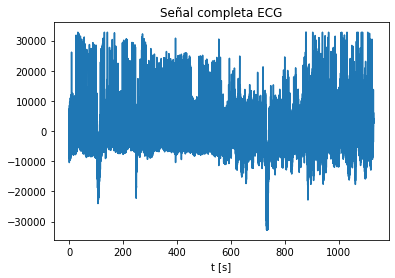

In [15]:
t = np.arange(start = 0, stop = N*Ts, step = Ts)
tqrs = t[qrs_detections] # vector tiempo de detecciones
ecg_detections = ecg_one_lead[qrs_detections].reshape((qrs_len,1))

plt.figure(8)
plt.plot(t,ecg_one_lead)
plt.title('Señal completa ECG')
plt.xlabel('t [s]')
plt.show()

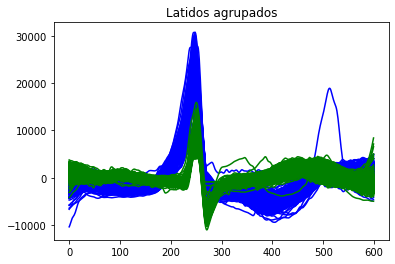

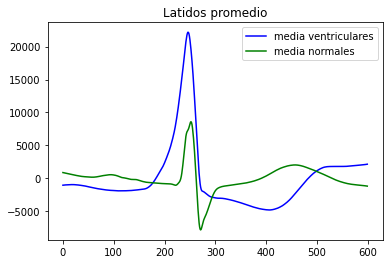

In [16]:
wleft = 250; wright = 350; w = wleft+wright
muestras_ecg  = np.zeros((wleft+wright, qrs_len))

for i in range(qrs_len):
    x = qrs_detections[i]
    muestras_ecg[:,i] = ecg_one_lead[x-wleft : x+wright]
    sig.detrend(muestras_ecg[:,i], axis=0, overwrite_data=True)


ventriculares = (muestras_ecg[220,:] > 1700)
ventric_sample = muestras_ecg[:,ventriculares]
normales_sample = muestras_ecg[:,~ventriculares]

plt.figure(9)
plt.plot(ventric_sample, 'b', label='ventriculares')
plt.plot(normales_sample, 'g', label='normales')

plt.title('Latidos agrupados')
plt.show()

plt.figure(10)
plt.plot(np.mean(ventric_sample,  axis=1), 'b', label='media ventriculares')
plt.plot(np.mean(normales_sample, axis=1), 'g', label='media normales')
plt.title('Latidos promedio')
plt.legend(loc='upper right')
#plt.legend()
plt.show()

In [18]:
ecg_len =len(ecg_reposo)
nperseg = ecg_len//10
welch_f, welch_spec = sig.welch(ecg_one_lead,   fs=fs, window= 'blackman', nfft=ecg_len,  nperseg = nperseg,
                                noverlap=nperseg//2, average='median',  axis=0 )
Nm = len(muestras_ecg)
nperseg = Nm//10
welch_f_m, welch_spec_ecg = sig.welch(muestras_ecg,   fs=fs, window='blackman', nfft=2*w, nperseg = nperseg,
                                      noverlap=nperseg//2, average='median',  axis=0 )
media_spec = np.mean(welch_spec_ecg, axis=1)

total = np.sum(np.abs(media_spec))
threshold = 0.90 * total
val = 0

for y in reversed(range(int(np.max(media_spec)))):
    if media_spec[(media_spec > y)].sum() >= threshold:
        val = y
        break

BW = welch_f_m[(media_spec>val)]
fci = BW.min()
fcs = BW.max()
print("fci = " + str(fci))
print("fcs = " + str(fcs))
print("BW  = " + str(fcs-fci))

fci = 0.0
fcs = 41.66666666666667
BW  = 41.66666666666667


In [19]:
# filter design
ripple = 0 / 2 # dB
atenuacion = 40 / 2 # dB

ws1 = fci+0.1 #Hz
wp1 = fci+1   #Hz
wp2 = fcs-5   #Hz
ws2 = fcs+5   #Hz

nyquist = fs/2

frecs = np.array([0.0, ws1, wp1, wp2, ws2, nyquist]) / nyquist
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyquist, ws=np.array([ws1, ws2]) / nyquist, 
                              gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')


In [20]:
ecg_filtrada = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead) 

# Espectro filtrado
len_filtrado = len(ecg_filtrada)
nperseg = len_filtrado//10
f_iir, spec_filt = sig.welch(ecg_filtrada,   fs=fs, window= 'boxcar', nfft= len_filtrado , nperseg= nperseg,
                             noverlap=nperseg//2, average='median',  axis=0 )



Visualizo resultado de los espectros

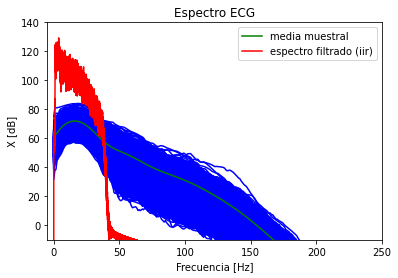

In [23]:

plt.figure(11)
bfrec = (welch_f_m <= fs/2)
specdB = 20* np.log10( np.abs(welch_spec_ecg))
plt.plot(welch_f_m[bfrec],specdB[bfrec], 'b')

bfrec = (welch_f_m <= fs/2)
media_specdB = 20* np.log10( np.abs(media_spec))
plt.plot(welch_f_m[bfrec],media_specdB[bfrec], 'g', label='media muestral')

bfrec = (f_iir <= fs/2)
spec_filtdB = 20* np.log10( np.abs(spec_filt))
plt.plot(f_iir[bfrec],spec_filtdB[bfrec], 'r', label='espectro filtrado (iir)')



plt.legend()
plt.xlabel('Frecuencia [Hz]'), plt.ylabel('X [dB]')
plt.xlim([-5, 250]), plt.ylim([-10, 140])
plt.title('Espectro ECG')
plt.show()